This demo will walk through two networks - a bi-directional LSTM and a temporal CNN. The bi-directional LSTM is trained with a pre-trained embedding that it then improves upon. 
The dataset is the Ditigal Music reviews from: http://jmcauley.ucsd.edu/data/amazon/ and the pre-trained word embedding is Google News' 300d vector which can be downloaded from https://code.google.com/archive/p/word2vec/. Please download the dataset and model from those locations. The terms and conditions of the data set license apply. Intel does not grant any rights to the data files.

In this example we are taking the most positive and most negative reviews from that dataset, and using simple normalization techniques. More complex techniques and larger datasets can be applied to get better results as currently the networks are overfitting in the examples. We will discuss some strategies to mitigate overfitting.

Everything can be run on a laptop, Python 3.6 is used, though it should all work in Python 2.7 as well.

In [1]:
import numpy as np
import pandas as pd 
import pickle
import json
import gensim
import os
import re

from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, Bidirectional, LSTM, regularizers
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, Trials

Using TensorFlow backend.


In [2]:
# Change these to match your file paths :)
filename = '/data_path/reviews_Digital_Music_5.json' #64,706 reviews

In [3]:
model_path = "model_path/GoogleNews-vectors-negative300.bin"
word_vector_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [4]:
def normalize(txt, vocab=None, replace_char=' ',
                max_length=300, pad_out=False,
                to_lower=True, reverse = False,
                truncate_left=False, encoding=None,
                letters_only=False):
  
    txt = txt.split()
    # Remove HTML
    # This will keep characters and other symbols
    txt = [re.sub(r'http:.*', '', r) for r in txt]
    txt = [re.sub(r'https:.*', '', r) for r in txt]
    
    txt = ( " ".join(txt))
    # Remove non-emoticon punctuation and numbers
    txt = re.sub("[.,!0-9]", " ", txt)
    if letters_only: 
        txt = re.sub("[^a-zA-Z]", " ", txt)
    txt = " ".join(txt.split())
    # store length for multiple comparisons
    txt_len = len(txt)

    if truncate_left:
        txt = txt[-max_length:]
    else:
        txt = txt[:max_length]
    # change case
    if to_lower:
        txt = txt.lower()
    # Reverse order
    if reverse:
        txt = txt[::-1]
    # replace chars
    if vocab is not None:
        txt = ''.join([c if c in vocab else replace_char for c in txt])
    # re-encode text
    if encoding is not None:
        txt = txt.encode(encoding, errors="ignore")
    # pad out if needed
    if pad_out and max_length>txt_len:
        txt = txt + replace_char * (max_length - txt_len)
    return txt

In [5]:
# What does this normalization function look like?
normalize("This is A sentence. with things! 123 :) and a link https://gitub.com")

'this is a sentence with things :) and a link'

In [6]:
def balance(df):
    print("Balancing the classes")
    type_counts = df['Sentiment'].value_counts()
    min_count = min(type_counts.values)

    balanced_df = None
    for key in type_counts.keys():

        df_sub = df[df['Sentiment']==key].sample(n=min_count, replace=False)
        if balanced_df is not None:
            balanced_df = balanced_df.append(df_sub)
        else:
            balanced_df = df_sub
    return balanced_df

Some of the larger Amazon datasts have to be loaded line by line as they are too large to be directly read into a Pandas DataFrame, but the smaller files may be read directly. I'm also changing the reviews into a sentiment, mapping the 1 stars as negative and 5 stars as positive. This function can be modified as desired, or you can keep the stars and use that as your prediction mechanism.

In [7]:
good_columns = [
    "overall", 
    "reviewText", 
    "summary"
]

def review_to_sentiment(review):
    # Review is coming in as overall (the rating, reviewText, and summary)
    # this then cleans the summary and review and gives it a positive or negative value
    norm_text = normalize(review[2] + " " + review[1])
    if review[0] ==5:
        return ['positive', norm_text]
    elif review[0] ==1:
        return ['negative', norm_text]
    else:
        return ['other', norm_text]
    


data = []
with open(filename, 'r') as f:
    for line in f:
        data_line = json.loads(line)
        selected_row = []
        for item in good_columns:
            selected_row.append(data_line[item])
        # as we read in, clean
        data.append(review_to_sentiment(selected_row))
        
amazon = pd.DataFrame(data, columns=['Sentiment', 'clean_text'], dtype=str)



In [8]:
# For this demo lets just keep one and five stars the others are marked 'other
amazon = amazon[amazon['Sentiment'].isin(['positive', 'negative'])]
amazon.head()

,Sentiment,clean_text
0,positive,"enya's last great album it's hard to believe ""..."
1,positive,enya at her most elegant a clasically-styled a...
2,positive,the best so far i never thought enya would rea...
3,positive,ireland produces good music this is the third ...
5,positive,dreamy unearthly magic continues with eire's o...


In [9]:
balanced_amazon = balance(amazon)
len(balanced_amazon)

Balancing the classes


5582

In [10]:
# Now go from the pandas into lists of text and labels

text = balanced_amazon['clean_text'].values
labels_0 = pd.get_dummies(balanced_amazon['Sentiment'])  # mapping of the labels with dummies (has headers)
labels = labels_0.values # removes the headers

In [11]:
# Perform the Train/test split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(text,labels, test_size = 0.2, random_state = 42)

In [12]:
# What does the data look like?
# It is a one-hot encoding of the label, either positive or negative
Y_train_[:5]

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [13]:
X_train_[42]

'a true poet gil scott-heron is one of the greatest poets the world has ever produced his words still hit home very underrated when folks talk about lyrical genius but he has written songs that are timeless&amp;very much in your face&amp;mind the music is great as well solid production&amp;arrangemen'

In [14]:
### Now for a simple bidirectional LSTM algorithm we set our feature sizes and train a tokenizer
# First we Tokenize and get the data into a form that the model can read - this is BoW
# In this cell we are also going to define some of our hyperparameters

max_fatures = 2000
max_len=300
batch_size = 32
embed_dim = 300
lstm_out = 140

dense_out=len(labels[0]) #length of features
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train_)
X_train = tokenizer.texts_to_sequences(X_train_)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')

X_test = tokenizer.texts_to_sequences(X_test_)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

word_index = tokenizer.word_index

In [15]:
# Now what does our data look like?
# Tokenizer creates a BOW encoding, which is then going to be fed into our Embedding matrix
# This will be used by the model to build up a word embedding
X_test[42]

array([  66,   82,   62,   16,  867,    8,   35, 1181,  593,   21,    1,
        117, 1034,   31,  246,   10,    2,    7,   93,   10,  139,    7,
        137,    3,  161,  144,    2,    7,  112,    4,    5,    1,  123,
        149,   46,   31,   69,  179,    3, 1145,  359,    6, 1868, 1512,
         10,   21,  463,  823,    7,  349,   10,   38,  484,   12,    7,
        462, 1356,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [16]:
# What does a word vector look like?
# Ahhhh, like a bunch of numbers
word_vector_model.word_vec('hi')

array([-1.65039062e-01,  2.04101562e-01,  1.30859375e-01,  2.87109375e-01,
       -1.68945312e-01, -3.66210938e-03,  1.72851562e-01, -2.75390625e-01,
       -3.61328125e-02,  3.19824219e-02,  6.34765625e-02, -7.17773438e-02,
       -3.00781250e-01, -7.42187500e-02,  3.12500000e-02,  6.44531250e-02,
        6.54296875e-02,  6.29882812e-02,  1.50390625e-01, -3.06640625e-01,
       -3.97949219e-02, -9.37500000e-02,  1.98974609e-02, -1.44653320e-02,
       -9.66796875e-02, -1.00585938e-01, -2.92968750e-01, -5.59082031e-02,
        4.16015625e-01, -2.22656250e-01,  1.45507812e-01, -3.34472656e-02,
        1.84326172e-02, -1.62109375e-01, -1.12304688e-01, -1.78710938e-01,
       -1.92382812e-01, -7.87353516e-03,  3.32031250e-01,  6.54296875e-02,
       -6.44531250e-02, -1.39648438e-01,  3.84765625e-01,  2.38281250e-01,
       -1.00097656e-01,  1.17675781e-01, -1.16699219e-01, -8.69140625e-02,
        4.66308594e-02,  1.19140625e-01, -2.44140625e-01,  1.45507812e-01,
        2.94921875e-01,  

In [17]:
print('Prepare the embedding matrix')

# prepare embedding matrix
num_words = min(max_fatures, len(word_index))
embedding_matrix = np.zeros((num_words, embed_dim))
for word, i in word_index.items():
    if i >= max_len:
        continue
    # words not found in embedding index will be all-zeros.
    if word in word_vector_model.vocab:
        embedding_matrix[i] = word_vector_model.word_vec(word)

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = True to fine tune the embeddings
embedding_layer = Embedding(num_words,
                            embed_dim,
                            weights=[embedding_matrix],
                            input_length=max_fatures,
                            trainable=True)

Prepare the embedding matrix


In [19]:
# Define the model using the pre-trained embedding
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(lstm_out, recurrent_dropout=0.5, activation='tanh'))(embedded_sequences)
preds = Dense(dense_out, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
model_hist_embedding = model.fit(X_train, Y_train_, epochs = 20, batch_size=batch_size, verbose = 2,
                        validation_data=(X_test,Y_test_))

Train on 4465 samples, validate on 1117 samples
Epoch 1/20
 - 85s - loss: 0.4680 - acc: 0.7783 - val_loss: 0.3523 - val_acc: 0.8496
Epoch 2/20
 - 84s - loss: 0.2781 - acc: 0.8876 - val_loss: 0.3443 - val_acc: 0.8442
Epoch 3/20
 - 83s - loss: 0.1968 - acc: 0.9221 - val_loss: 0.3700 - val_acc: 0.8308
Epoch 4/20
 - 84s - loss: 0.1469 - acc: 0.9451 - val_loss: 0.4000 - val_acc: 0.8505
Epoch 5/20
 - 82s - loss: 0.0894 - acc: 0.9711 - val_loss: 0.4802 - val_acc: 0.8478
Epoch 6/20
 - 82s - loss: 0.0542 - acc: 0.9828 - val_loss: 0.5430 - val_acc: 0.8415
Epoch 7/20
 - 83s - loss: 0.0479 - acc: 0.9850 - val_loss: 0.5724 - val_acc: 0.8165
Epoch 8/20
 - 83s - loss: 0.0337 - acc: 0.9908 - val_loss: 0.6893 - val_acc: 0.8487
Epoch 9/20
 - 83s - loss: 0.0090 - acc: 0.9989 - val_loss: 0.7429 - val_acc: 0.8397
Epoch 10/20
 - 81s - loss: 0.0110 - acc: 0.9975 - val_loss: 0.8305 - val_acc: 0.8424
Epoch 11/20
 - 84s - loss: 0.0045 - acc: 0.9989 - val_loss: 0.8527 - val_acc: 0.8353
Epoch 12/20
 - 82s - loss:

## Temporal Convolutional Networks
How does the simple bidirectional LSTM compare to the temporal convolutional network?

This As defined in "Text Understanding from Scratch" by Zhang, LeCun 2015 https://arxiv.org/pdf/1502.01710v4.pdf this model is a series of 1D CNNs, with a maxpooling and fully connected layers.

In [21]:
zhang_lecun_vocab=list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}") 
vocab_hash = {b: a for a, b in enumerate(zhang_lecun_vocab)}

def to_one_hot(txt, length = max_len, vocab=vocab_hash):
    
    vocab_size = len(vocab.keys())
    one_hot_vec = np.zeros((vocab_size, length), dtype=np.float32)
    # run through txt and "switch on" relevant positions in one-hot vector
    for idx, char in enumerate(txt):
        try:
            vocab_idx = vocab_hash[char]
            one_hot_vec[vocab_idx, idx] = 1
        # raised if character is out of vocabulary
        except:
            #print(char)
            pass
    return one_hot_vec

In [22]:
to_one_hot("a cat ate foccacia")

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
def one_hot_cnn(dense_out, max_len=300, frame='small'):

    if frame == 'large':
        cnn_size = 1024
        fully_connected = [2048,2048,dense_out]
    elif frame =='small':
        cnn_size = 256
        fully_connected = [1024,1024,dense_out]
    elif frame =='tiny':
        cnn_size = 128
        fully_connected = [512,512,dense_out]
        

    model = Sequential()

    model.add(Conv1D(cnn_size, 7, padding='same', input_shape=(67, max_len)))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 22 x cnn_size
    model.add(Conv1D(cnn_size, 7, padding='same'))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    model.add(Conv1D(cnn_size,3, padding='same'))

    # #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size, 3, padding='same'))
    model.add(MaxPooling1D(pool_size=3))
    
    model.add(Flatten())

    #Fully Connected Layers

    #Input is 512 Output is 1024/2048
    model.add(Dense(fully_connected[0]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is 1024/2048
    model.add(Dense(fully_connected[1]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is dense_out size (number of classes)
    model.add(Dense(fully_connected[2]))
    model.add(Activation('softmax'))

    #Stochastic gradient parameters as set by paper
    sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [24]:
X_train_a_ = [to_one_hot(x) for x in X_train_]
X_test_a_ = [to_one_hot(x) for x in X_test_]

X_train_a = np.asarray(X_train_a_)
Y_train_a = Y_train_

X_test_a = np.asarray(X_test_a_)
Y_test_a = Y_test_

print(X_train_a.shape)

(4465, 67, 300)


In [35]:
model_cnn = one_hot_cnn(dense_out, frame='small')
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 67, 256)           537856    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 22, 256)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 22, 256)           459008    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 7, 256)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 7, 256)            196864    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 7, 256)            196864    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 7, 256)            196864    
__________

In [36]:
model_hist_cnn = model_cnn.fit(X_train_a, Y_train_a, batch_size=64, epochs=20, verbose=1, 
          validation_data=(X_test_a,Y_test_a))

Train on 4465 samples, validate on 1117 samples
Epoch 1/20
4465/4465 [==============================] - 12s 3ms/step - loss: 0.7110 - acc: 0.5050 - val_loss: 0.6953 - val_acc: 0.4879
Epoch 2/20
4465/4465 [==============================] - 12s 3ms/step - loss: 0.7048 - acc: 0.5024 - val_loss: 0.6945 - val_acc: 0.4879
Epoch 3/20
4465/4465 [==============================] - 11s 3ms/step - loss: 0.7010 - acc: 0.5122 - val_loss: 0.6922 - val_acc: 0.5264
Epoch 4/20
4465/4465 [==============================] - 12s 3ms/step - loss: 0.6973 - acc: 0.5131 - val_loss: 0.6916 - val_acc: 0.5273
Epoch 5/20
4465/4465 [==============================] - 12s 3ms/step - loss: 0.6886 - acc: 0.5442 - val_loss: 0.6920 - val_acc: 0.5228
Epoch 6/20
4465/4465 [==============================] - 11s 3ms/step - loss: 0.6528 - acc: 0.6206 - val_loss: 0.7426 - val_acc: 0.4960
Epoch 7/20
4465/4465 [==============================] - 12s 3ms/step - loss: 0.4952 - acc: 0.7695 - val_loss: 0.8299 - val_acc: 0.5389
Epoch 8

How do these different performances compare?

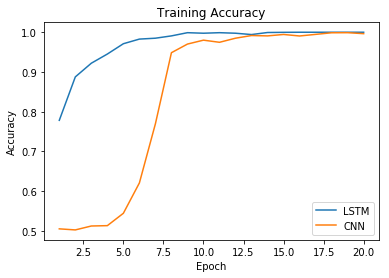

In [37]:
# Training Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['acc'])
plt.plot(x, model_hist_cnn.history['acc'])
plt.legend(['LSTM', 'CNN'], loc='lower right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training Accuracy")
plt.show()

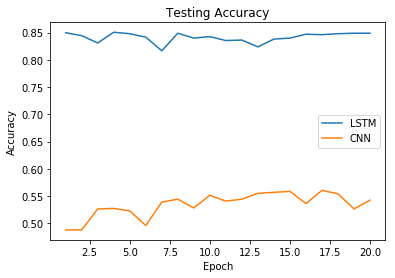

In [38]:
# Testing Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['val_acc'])
plt.plot(x, model_hist_cnn.history['val_acc'])
plt.legend(['LSTM', 'CNN'], loc='right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Testing Accuracy")
plt.show()

So Basically they are all overfitting!
This is a small dataset to show what can be done with deep learning